In [1]:
import numpy as np
import pandas as pd
import datetime

import sys
sys.path.append('../scripts')

from yahoo_stock_data import YahooStockData
from alphavantage import get_quarterly_reports
from data_handler import DataHandler
from ta_features import add_ta_features
from feature_selection import FeatureSelector
from random_forest import AlgoRandomForest

In [6]:
TIMEFRAME = -1
TARGET = 'High'
LOG_RETURN = True
TEST_SIZE = 0.2
MAX_NUM_FEATURES = 50
ticker = 'MSFT'
alpha_key = 'INSERT_KEY_HERE'

In [4]:
def merge_fundamentals(si_data, fun_data):
    def add_fundamentals(row, params, nrows):
        if row['Date'] >= params[1]:
            params[0] = params[1]
            params[2] += 1
            if params[2] < nrows-1:
                params[1] = fun_data.iloc[params[2]+1]['fiscalDateEnding']
            else:
                params[1] = pd.to_datetime("today") + datetime.timedelta(days=1)
            #print(cur_idx, fun_data.iloc[cur_idx]['fiscalDateEnding'])
        for col in fun_data.columns:
            row[col] = fun_data.iloc[params[2]][col]
        return row
    nrows = fun_data.shape[0]
    cur_quarter = fun_data.iloc[0]['fiscalDateEnding']
    nxt_quarter = fun_data.iloc[1]['fiscalDateEnding']
    cur_idx = 0
    params = [cur_quarter, nxt_quarter, cur_idx]
    si_data = si_data.apply(add_fundamentals, axis=1, args = (params, nrows))
    return si_data

In [10]:
fund_df = get_quarterly_reports(ticker, alpha_key)
start_date = fund_df.iloc[0]['fiscalDateEnding'].strftime('%Y-%m-%d')

si_from_yahoo = YahooStockData(ticker)
si_data = si_from_yahoo.get_data(start_date)
si_data.reset_index(inplace=True)

merged_data = merge_fundamentals(si_data, fund_df)
merged_data.drop(columns=['fiscalDateEnding'], inplace=True)

data_w_features = add_ta_features(merged_data)
print(f'After technical analysis there are {data_w_features.shape[1]} features')

[*********************100%***********************]  1 of 1 completed
After technical analysis there are 278 features


In [11]:
data_handler = DataHandler(data_w_features, TARGET, TIMEFRAME, LOG_RETURN, TEST_SIZE)

fselector = FeatureSelector(data_handler, MAX_NUM_FEATURES) # select 50 most important features
fselector.important_features.extend(['target', 'High', 'Close'])

data_w_reduced_features = data_w_features[fselector.important_features]
print(f'After feature selection, there are {data_w_reduced_features.shape[1]} features')

Start: gridsearch using xgboost
Best VALIDATION R^2 is 0.1015508799818774 with params: {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': 'reg:squarederror'}
TRAIN R^2 for best test params is 0.3645429959813994
After feature selection, there are 35 features


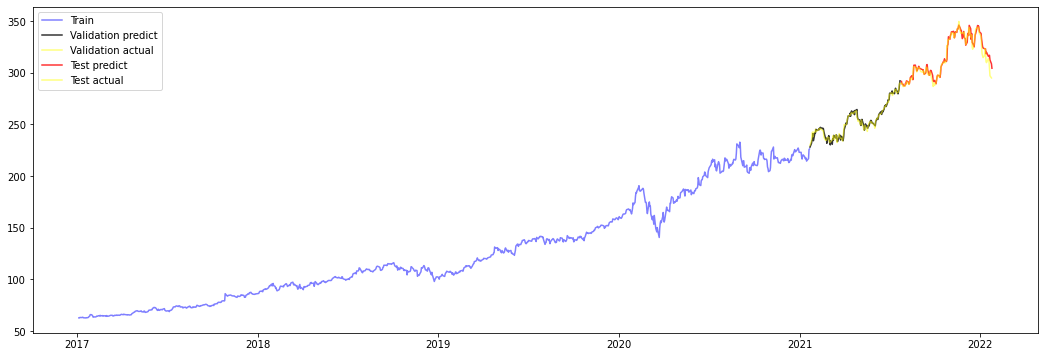

In [12]:
data_w_reduced_features.reset_index(inplace=True) # 'Date' needs to back as a column
data_handler = DataHandler(data_w_reduced_features, TARGET, TIMEFRAME, LOG_RETURN, TEST_SIZE)
algoRF = AlgoRandomForest(data_handler)
forecasts = algoRF.get_forecasts()
forecast, _, test_results = data_handler.process_forecasts(forecasts)

In [13]:
print(pd.DataFrame(test_results, index=['Test results'])) # must pass an index (for all scalar values) or change the columns to be a list
print()
print('Predicted value:')
print(forecast[-1]) 

                    mse       mae      rmse      mape
Test results  17.144935  2.868525  4.140644  0.009046

Predicted value:
304.40181399318925
